# Membrane Deflection

    Author: Stefan Wittwer
    E-mail: info@wittwer-datatools.ch
    

In [1]:
from wdtPy.WDFE import WDFE
from wdpPy.WDataView import WDataView
from wdpPy.WDomainFactory import WDomainFactory
from wdpPy.WDMeshFactory import WDMeshFactory

### Abstract
The class **_wdtPy.WDFE_** extends some functions of the packages **_fenics_** and **_mshr_** (www.fenics.org). It implements the properties and methods used to process partial differential equations (PDE) with the finite element method (FEM). 

This article demonstrates how to solve the steady-state Poisson equation for calculating the deflection $z(x, y)$ of a circular membrane under a position-depending pressure $p(x, y)$. The deflection will be assumed to be small against the radius of the circular domain. Therefore the tension $\sigma$ is set to be a constant.

In [2]:
wd_fe = WDFE('FE20200324.pvd')

## Problem Definition
The membrane is defined to be a two-dimensional circular domain $\Omega$ with radius $R$. As long as no external forces act $z = 0$ everywhere on the membrane. However, as soon as a pressure acts on the membrane there is a non-zero deflection on $\Omega$. The deflection is determined by the Poisson equation and a boundary condition. 

The corresponding Poisson equation reads
\begin{equation}
  \Delta z(x, y) = -\frac{1}{\sigma} p(x, y)
\end{equation}
and the Dirichlet boundary condition is
\begin{equation}
  z_D(x, y) = 0 \quad\quad x, y \in \partial \Omega
\end{equation}

The pressure $p(x, y)$ is the source function on the right side of the PDE and is given by a Gaussian shaped pressure load
\begin{equation}
  p(x, y) = \frac{p_0}{2\pi \Delta p} \exp\left(-\frac{1}{2\Delta p^2} 
    \left( (x - x_0)^2 + (y - y_0)^2 \right)\right)
\end{equation}
The parameters are:
* pressure amplitude $p_0$,
* distribution width $\Delta p$ of pressure distribution,
* center $(x_0, y_0)$ of pressure distribution (set to $(0, y_0)$ with $0 < y_0 < R$).


## Dimensionless Equations
With the transformations

* $x \rightarrow x/R$
* $y \rightarrow y/R$
* $z \rightarrow z/z_c$
* $y_0 \rightarrow y_0/R$

the dimensionless PDE is obtained:
\begin{equation}
\Delta z = -a \exp\left(-b^2 \left(x^2 + (y - y_0)^2 \right) \right)
\end{equation}
with 
\begin{eqnarray}
a & = & \frac{R^2 p_0}{2\pi \sigma z_c \Delta p} \\
b & = & \frac{R}{\sqrt{2} \Delta p}
\end{eqnarray}

In [3]:
# radius of domain
R = 0.8

# init domain factory
wdomain_factory = WDomainFactory()
wdomain_factory.SetRadius(R)

# create circle domain
wd_fe.Domain = wdomain_factory.CreateCircle()

## Preprocessing Stage
A preprocessing stage is run before the finite element simulation can be started. The first thing to do here is to create a mesh on the domain $\Omega$. Then a function space is created on the mesh domain. Finally the boundary conditions are defined.

In [4]:
wd_mesh = WDMeshFactory(wd_fe.Domain, n=48)  # change n for different resolutions

### Create Mesh
The mesh is created with the **_MeshFactory_** class. Once the mesh is successfully created it is displayed and saved to a VTK file type which can be visualized post process with the paraview tool (www.paraview.org). 

Number of coordinates: (4618, 2)


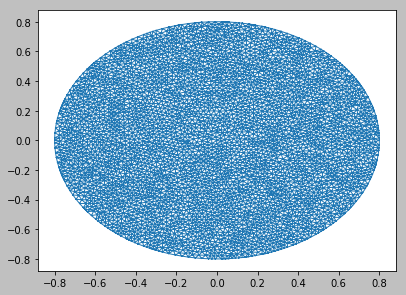

In [5]:
# create mesh
wd_fe.Mesh = wd_mesh.CreateMesh()

# print number of vertices
vertex = wd_fe.Mesh.coordinates()
print('Number of coordinates: {0}'.format(vertex.shape))

# save mesh to VTK file
wd_fe.SaveToVTK(wd_fe.Mesh)  # view mesh with paraview

# show mesh
wdv = WDataView()
wdv.CreateTriPlot(vertex)

### Create Function Space
In weak variational forms of PDE problems there are test and trial functions used to find the solution. The test function $v$ and the trial function $u$ are defined on the discrete function space of the mesh domain. The method **_DefineFunctionSpace()_** calls the **_FunctionSpace()_** method of Fenics (www.fenics.org) which takes the three following arguments:
* the mesh,
* the type of mesh element according www.femtable.org and
* the degree of the mesh element.

In [6]:
# define function space on mesh
# default: cell_type='P', cell_degree=1 (see www.femtable.org)
wd_fe.FSpace = wd_mesh.DefineFunctionSpace(wd_fe.Mesh)

### Define Boundary Conditions
The Dirichlet boundary condition is determined by the following arguments:
* a C-compatible string defining the formula of the boundary condition and
* an accuracy degree (typically equal to the degree of the mesh element).
Internally, the method defines a nested boolean function that decides whether a vertex is on a boundary or not.

In the present case we assume zero deflection on the entire boundary.

In [7]:
z_D = '0.0'  # C-compatible string formula
dbc = wd_fe.DefineDirichletBC(z_D, degree = 2)

## Processing Stage: FEM Computation
Now that the FEM problem has been fully defined in the preprocessing stage the FEM computation of the solution can start. First the source function $f(\vec{x})$ is defined. 

### Define Pressure Load
The method **_DefineSourceFunction()_** is used to set the source term function on the right side of the PDE. Here this function is called $p(x, y)$ and has the physical meaning of a pressure load acting on the membrane surface.

In [8]:
# define source function
p = 'a*exp(-pow(b, 2.0)*(pow(x[0], 2.0) + pow(x[1] - c, 2.0)))'
p = wd_fe.DefineSourceFunction(p, 2, {'a': 4.0, 'b': 8.0, 'c': 0.3})

### Define Variational Form
Second, the variational problem is implemented by defining the test and trial functions. The method **_DefineVariationalForm_** returns the bilinear form as well as the linear operator in the PDE.

In [9]:
# define variational problem
a, L = wd_fe.DefineVariationalForm(-p)

### Solve PDE
Finally the solution of the FEM problem is computed.

In [10]:
# compute solution
u = wd_fe.ComputeSteadyState(a, L)

## Postprocessing Stage
### Visualize Solution
The solution $z(x, y)$ is now ready to be investigated. Typically this is done by visualizing the numerical results of the FEM simulation.
An interactive and versatile visualization can be done with the application **_paraview_** (www.paraview.org) and the created VTK file **_FE20200324.pvd_**. The file contains the mesh in the first frame, and the scalar deflection field in the second frame. 

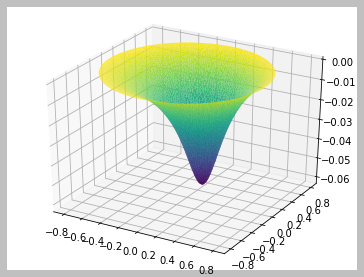

In [11]:
z = wd_fe.ComputeVertexValues(u)
wdv.CreateMeshSurface('z(x, y)', vertex[:, 0], vertex[:, 1], z)

### Visualize Pressure Load
The pressure load represented by the function $p(x, y)$ must be interpolated over the function space of the mesh, before it can be visualized in the same way as the solution above.

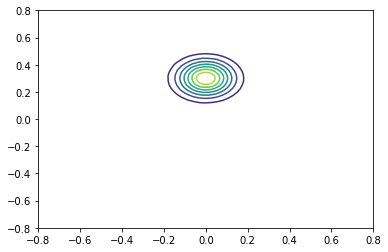

In [12]:
p = wd_fe.Interpolate(p)
q = [p(x, y) for x, y in zip(vertex[:, 0], vertex[:, 1])]
wdv.CreateMeshContour(vertex, q)

### Computational Errors
Finally, let's compute the error in the L2 norm and the maximum error at the vertices. This helps to describe the quality of the simulation results.

In [13]:
e_max = wd_fe.ComputeError(dbc, u)
print('error max = {0}'.format(e_max))

error max = 0.062274627371311266


### Save Results to VTK Files

In [14]:
wd_fe.SaveToVTK(u)
wd_fe.SaveToVTK(p)